In [4]:
import pandas
import plots
import datetime
import matplotlib 
import datetime
import sys

sys.path.append('../')
import database

pandas.plotting.register_matplotlib_converters()

In [5]:
db = database.SQLiteDatabase('power.sqlite')
sce_table = database.SceTable(db)
solar_table = database.SolarTable(db)

now = datetime.datetime.now()
today = datetime.datetime.now().date()

0:00:00.096911


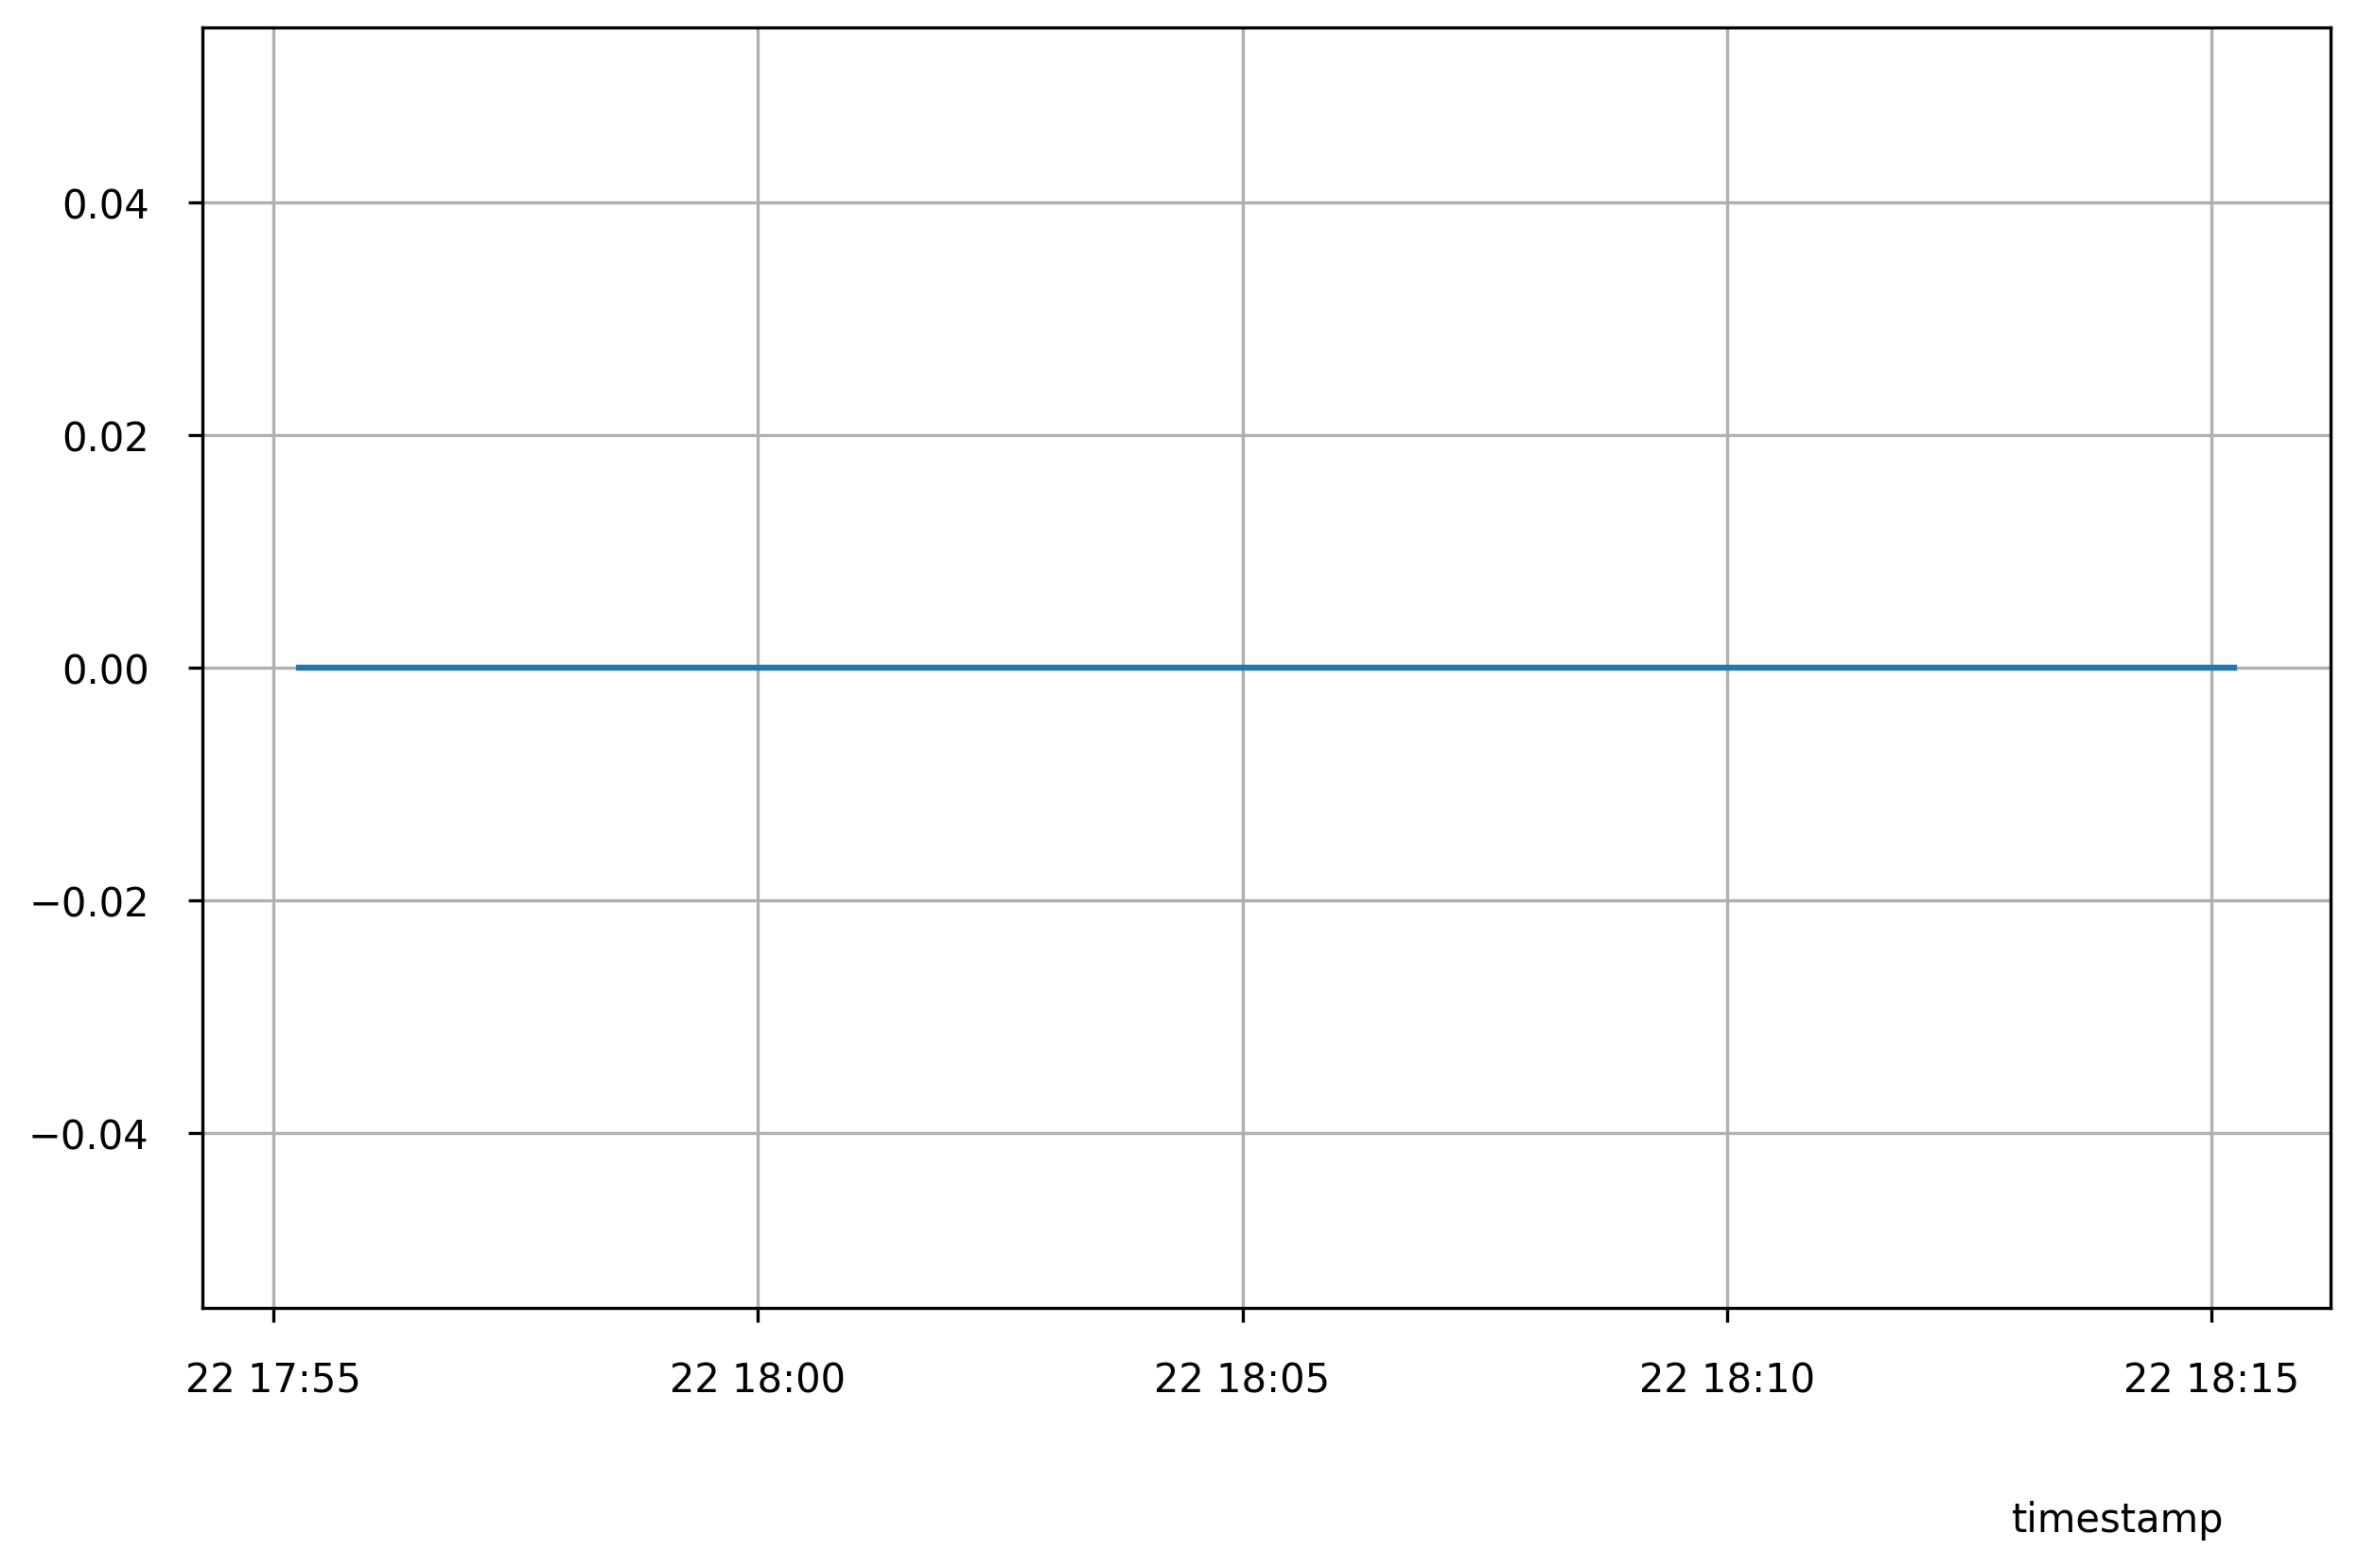

In [7]:
tick = datetime.datetime.now()

start = now - datetime.timedelta(days=5)
query = ''' SELECT timestamp, power FROM power 
            WHERE timestamp > '{start}'
            ORDER BY timestamp'''
query = query.format(start=start)
solar_power = pandas.read_sql(sql=query, con=db.engine, 
                              parse_dates='timestamp',
                              index_col='timestamp')

plot = plots.Plot()
plot.plot_pandas(solar_power['power'])
print(datetime.datetime.now()- tick)

0:00:00.081075


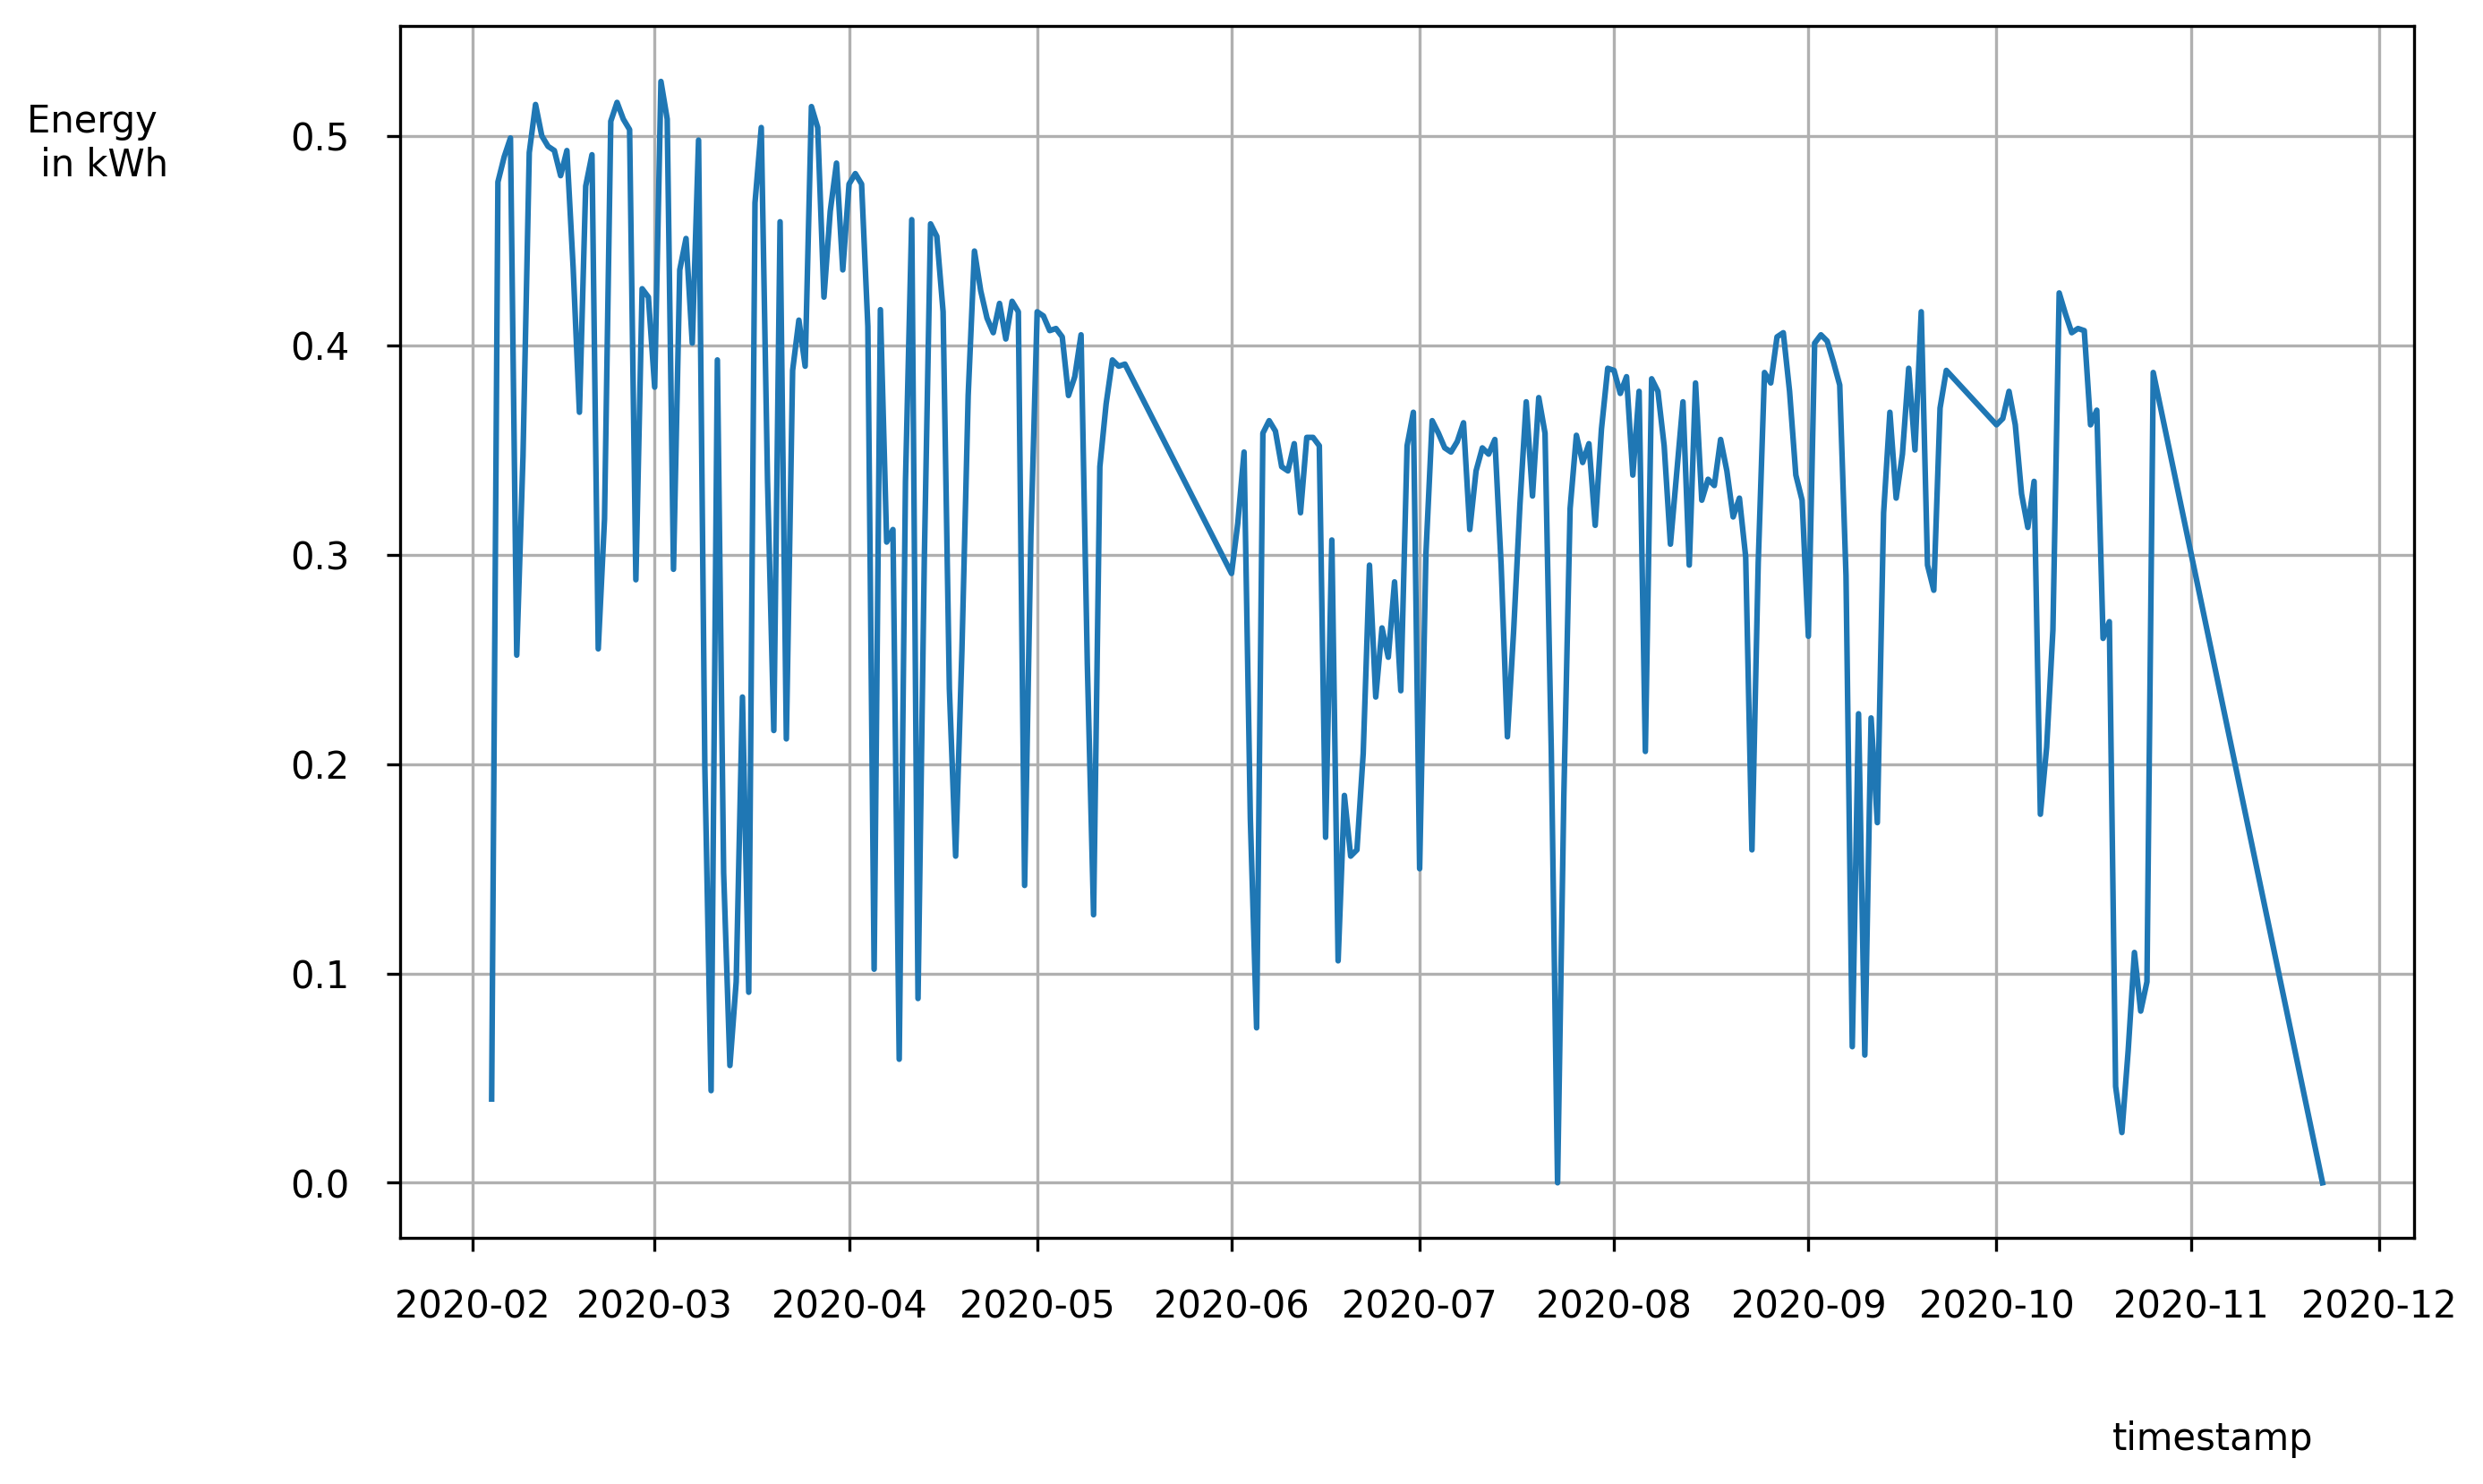

In [8]:
tick = datetime.datetime.now()
plot = plots.Plot()    

sql = 'SELECT * FROM day ORDER BY timestamp;'
days = pandas.read_sql(sql=sql, con=db.engine, 
                       parse_dates='timestamp',
                       index_col='timestamp')    
plot.plot_pandas(days['energy'])

plot.y_label('Energy \n in kWh')
plot.set_monthly_ticks()
print(datetime.datetime.now()- tick)

0:00:00.065698


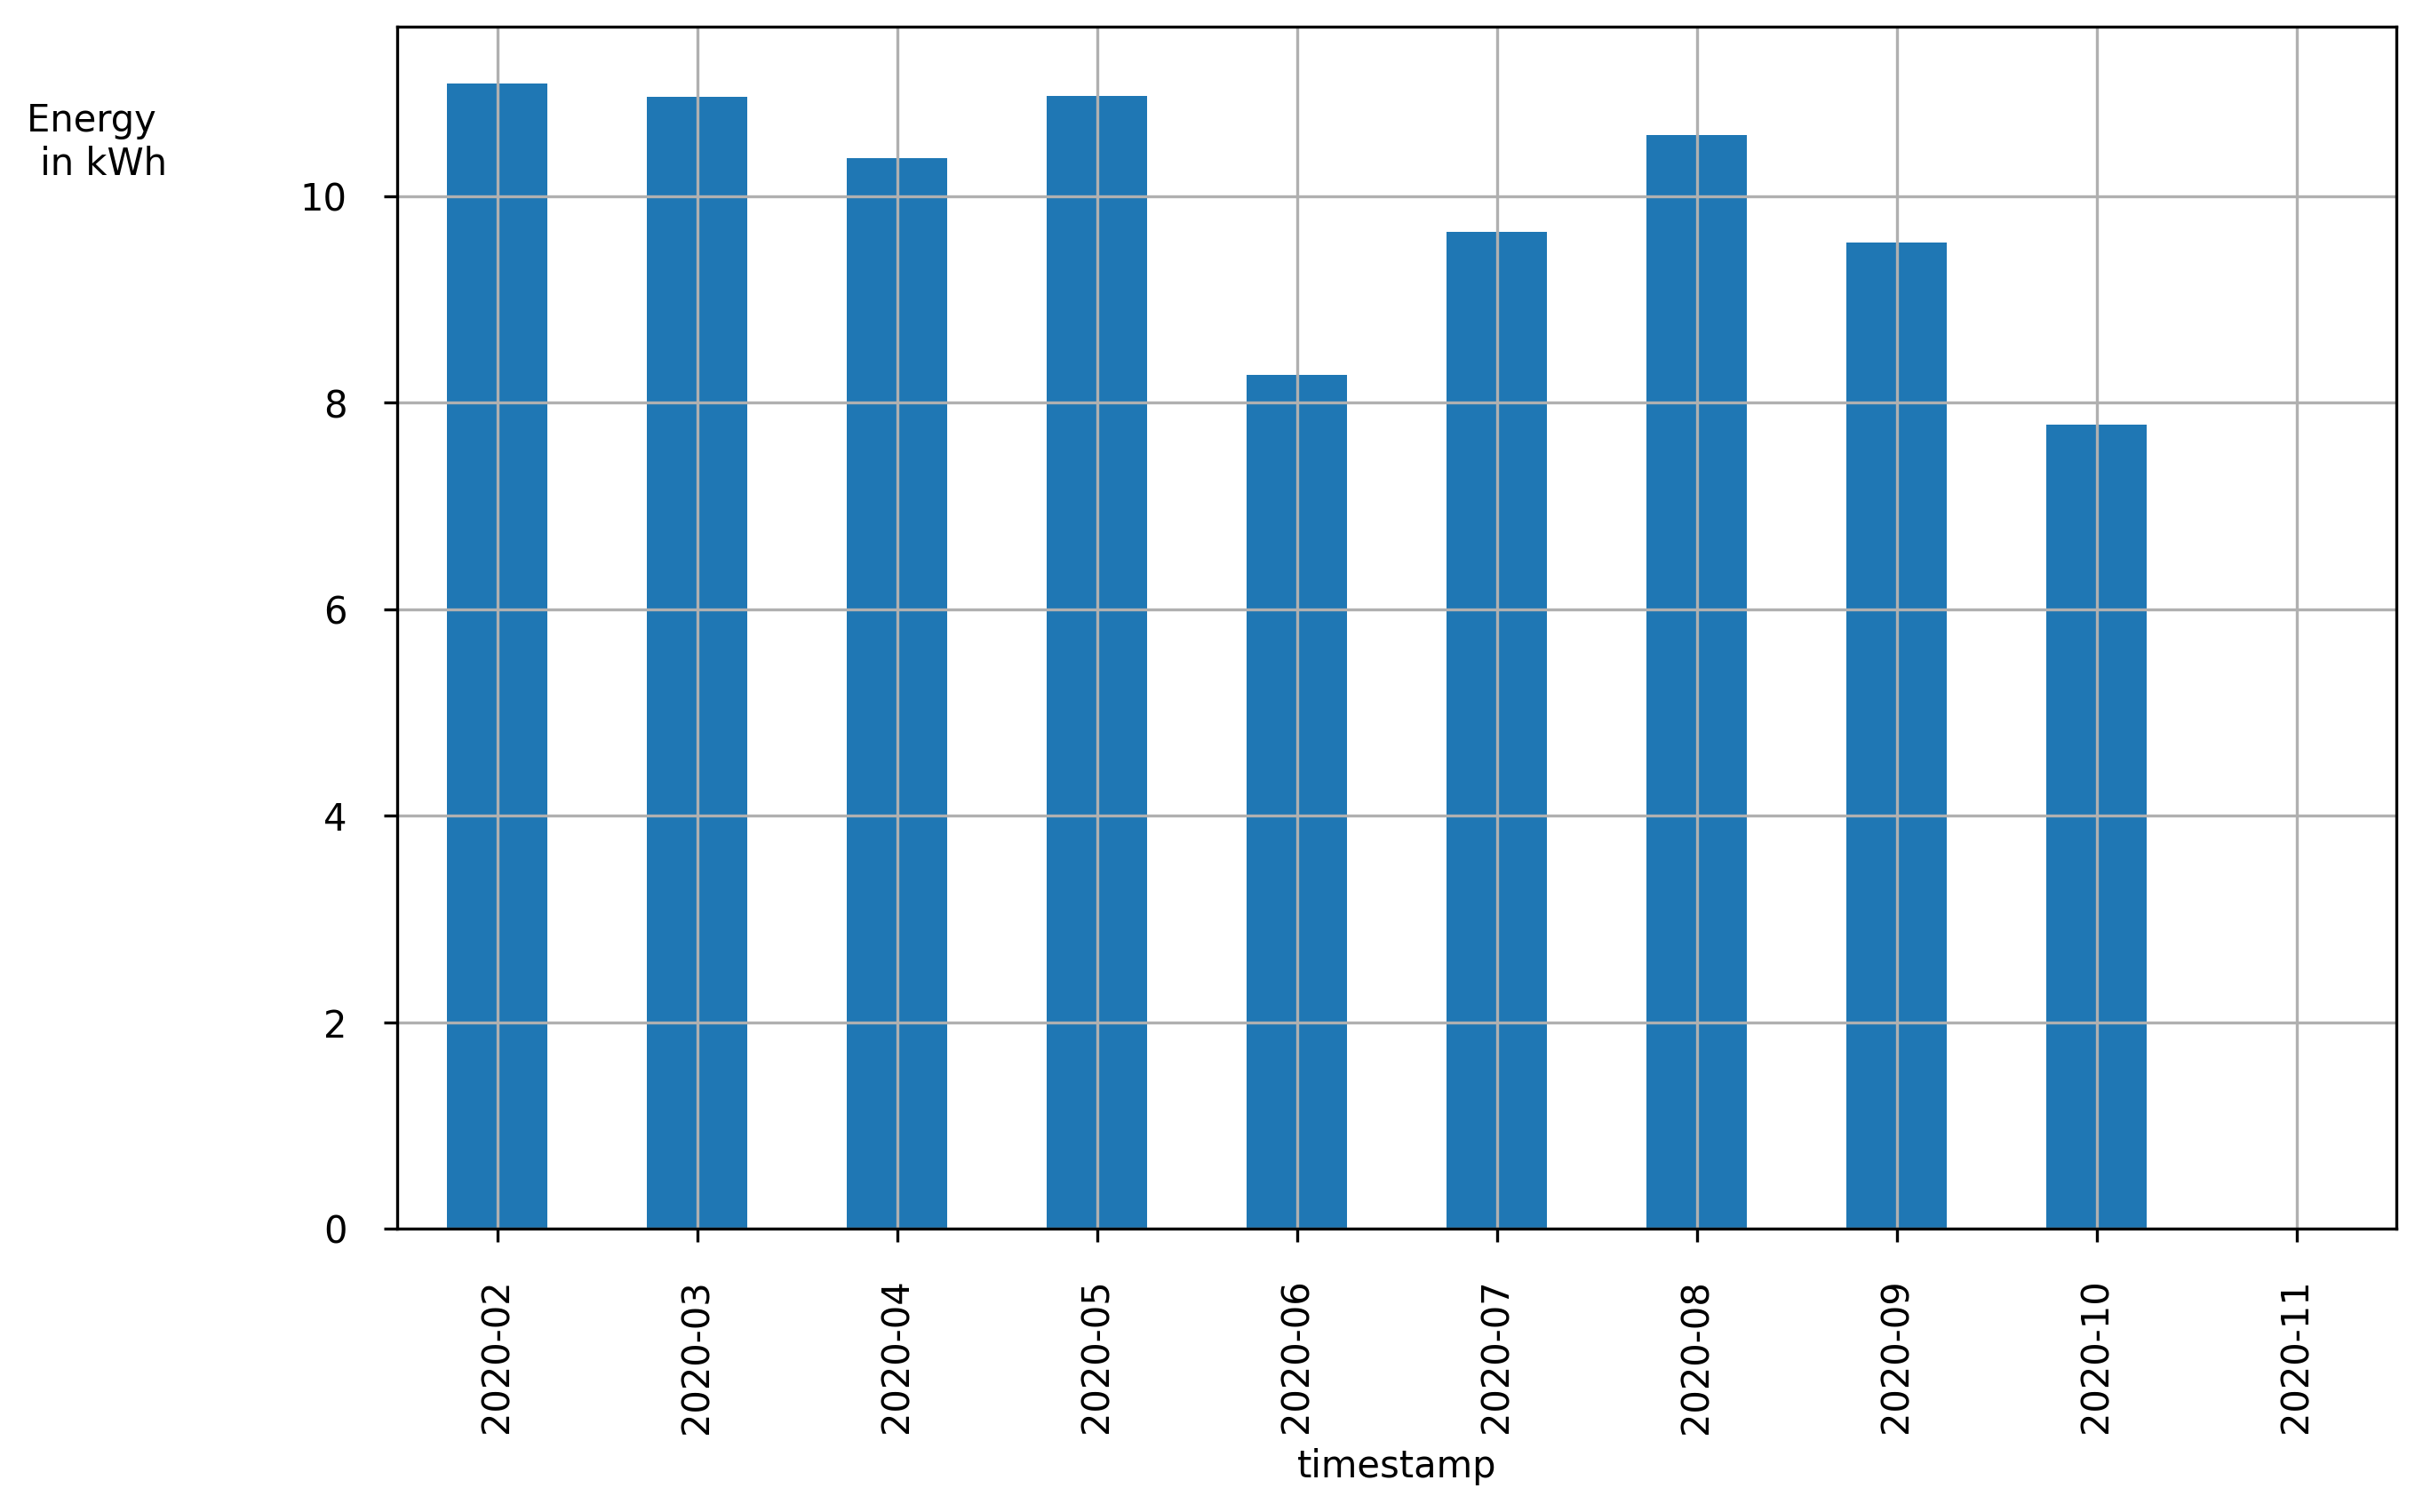

In [9]:
tick = datetime.datetime.now()
plot = plots.Plot()
query = 'SELECT timestamp, energy FROM month'
months = pandas.read_sql(sql=query, con=db.uri, 
                         parse_dates='timestamp',
                         index_col='timestamp')
months.index = months.index.to_period('M')
plot.plot_pandas_series(months['energy'], kind='bar')
plot.y_label('Energy \n in kWh')
print(datetime.datetime.now()- tick)

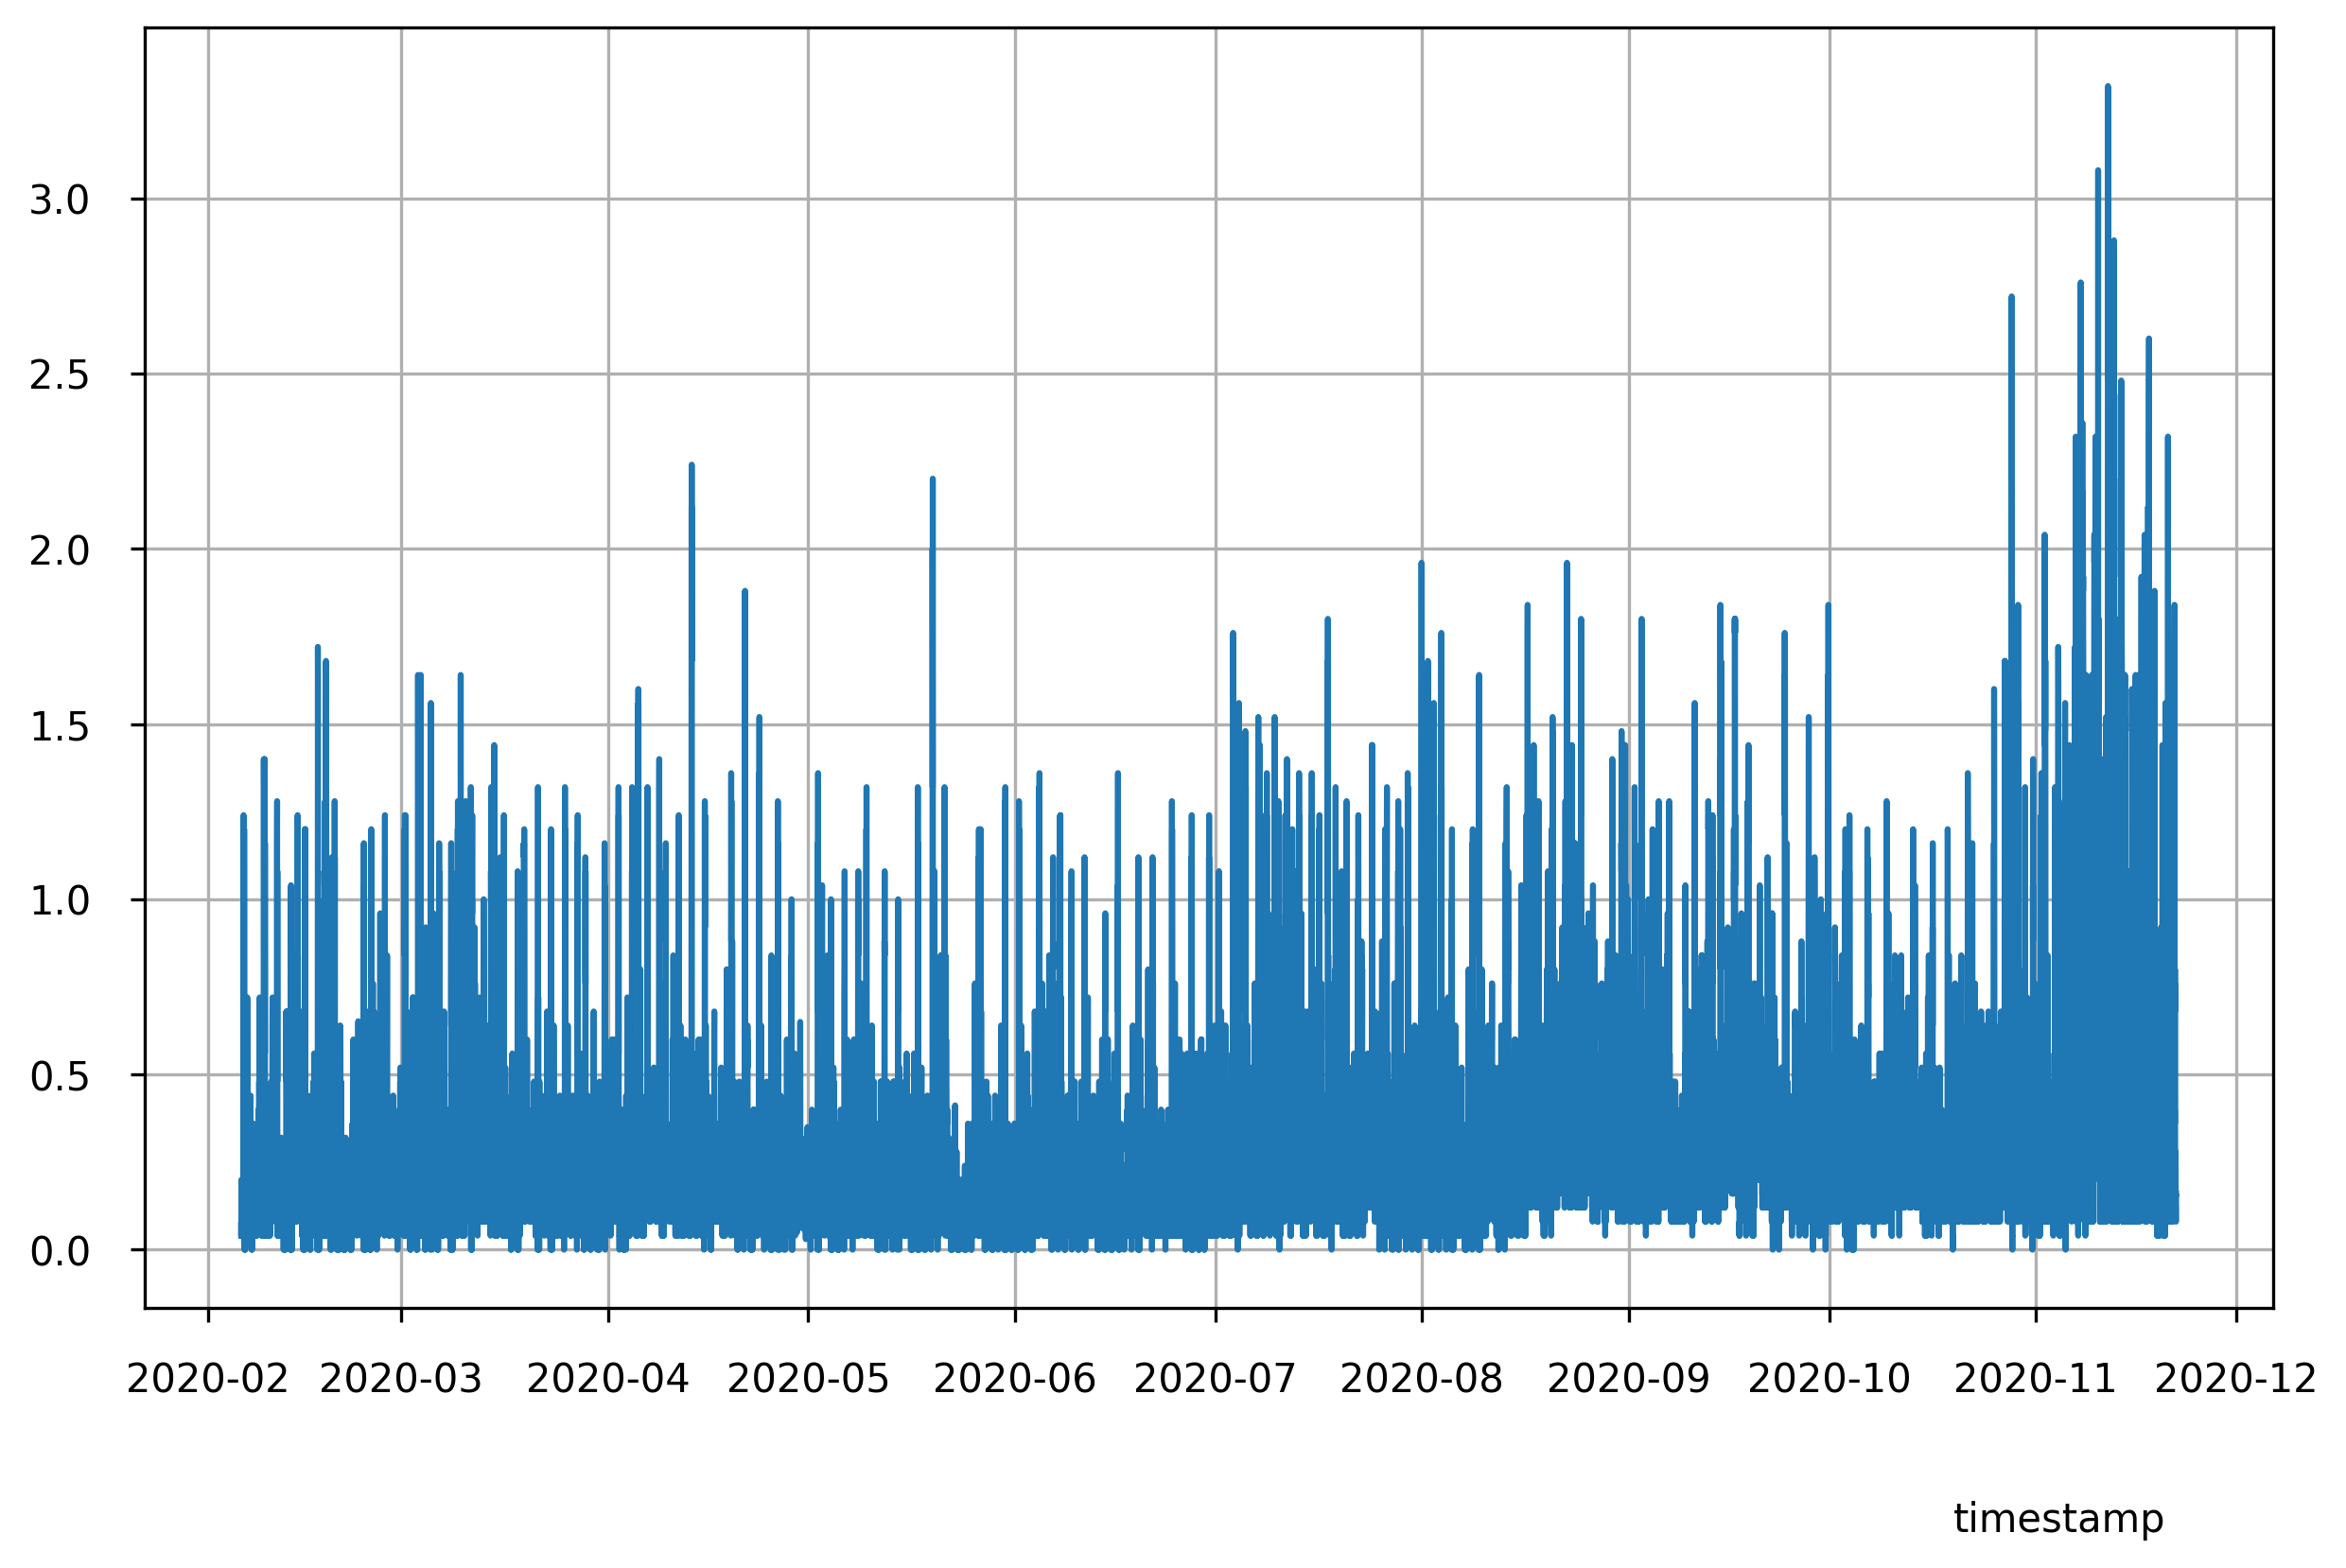

In [10]:
query = 'SELECT * FROM SCE WHERE timestamp>\'2020-02-06\' ORDER BY timestamp DESC'
sce = pandas.read_sql(sql=query, con=db.engine)
sce['timestamp'] = pandas.to_datetime(sce['timestamp'])
sce.set_index('timestamp', inplace=True)
plot = plots.Plot()
plot.plot_pandas(sce['power'], series_name='SCE')

0:00:00.054331


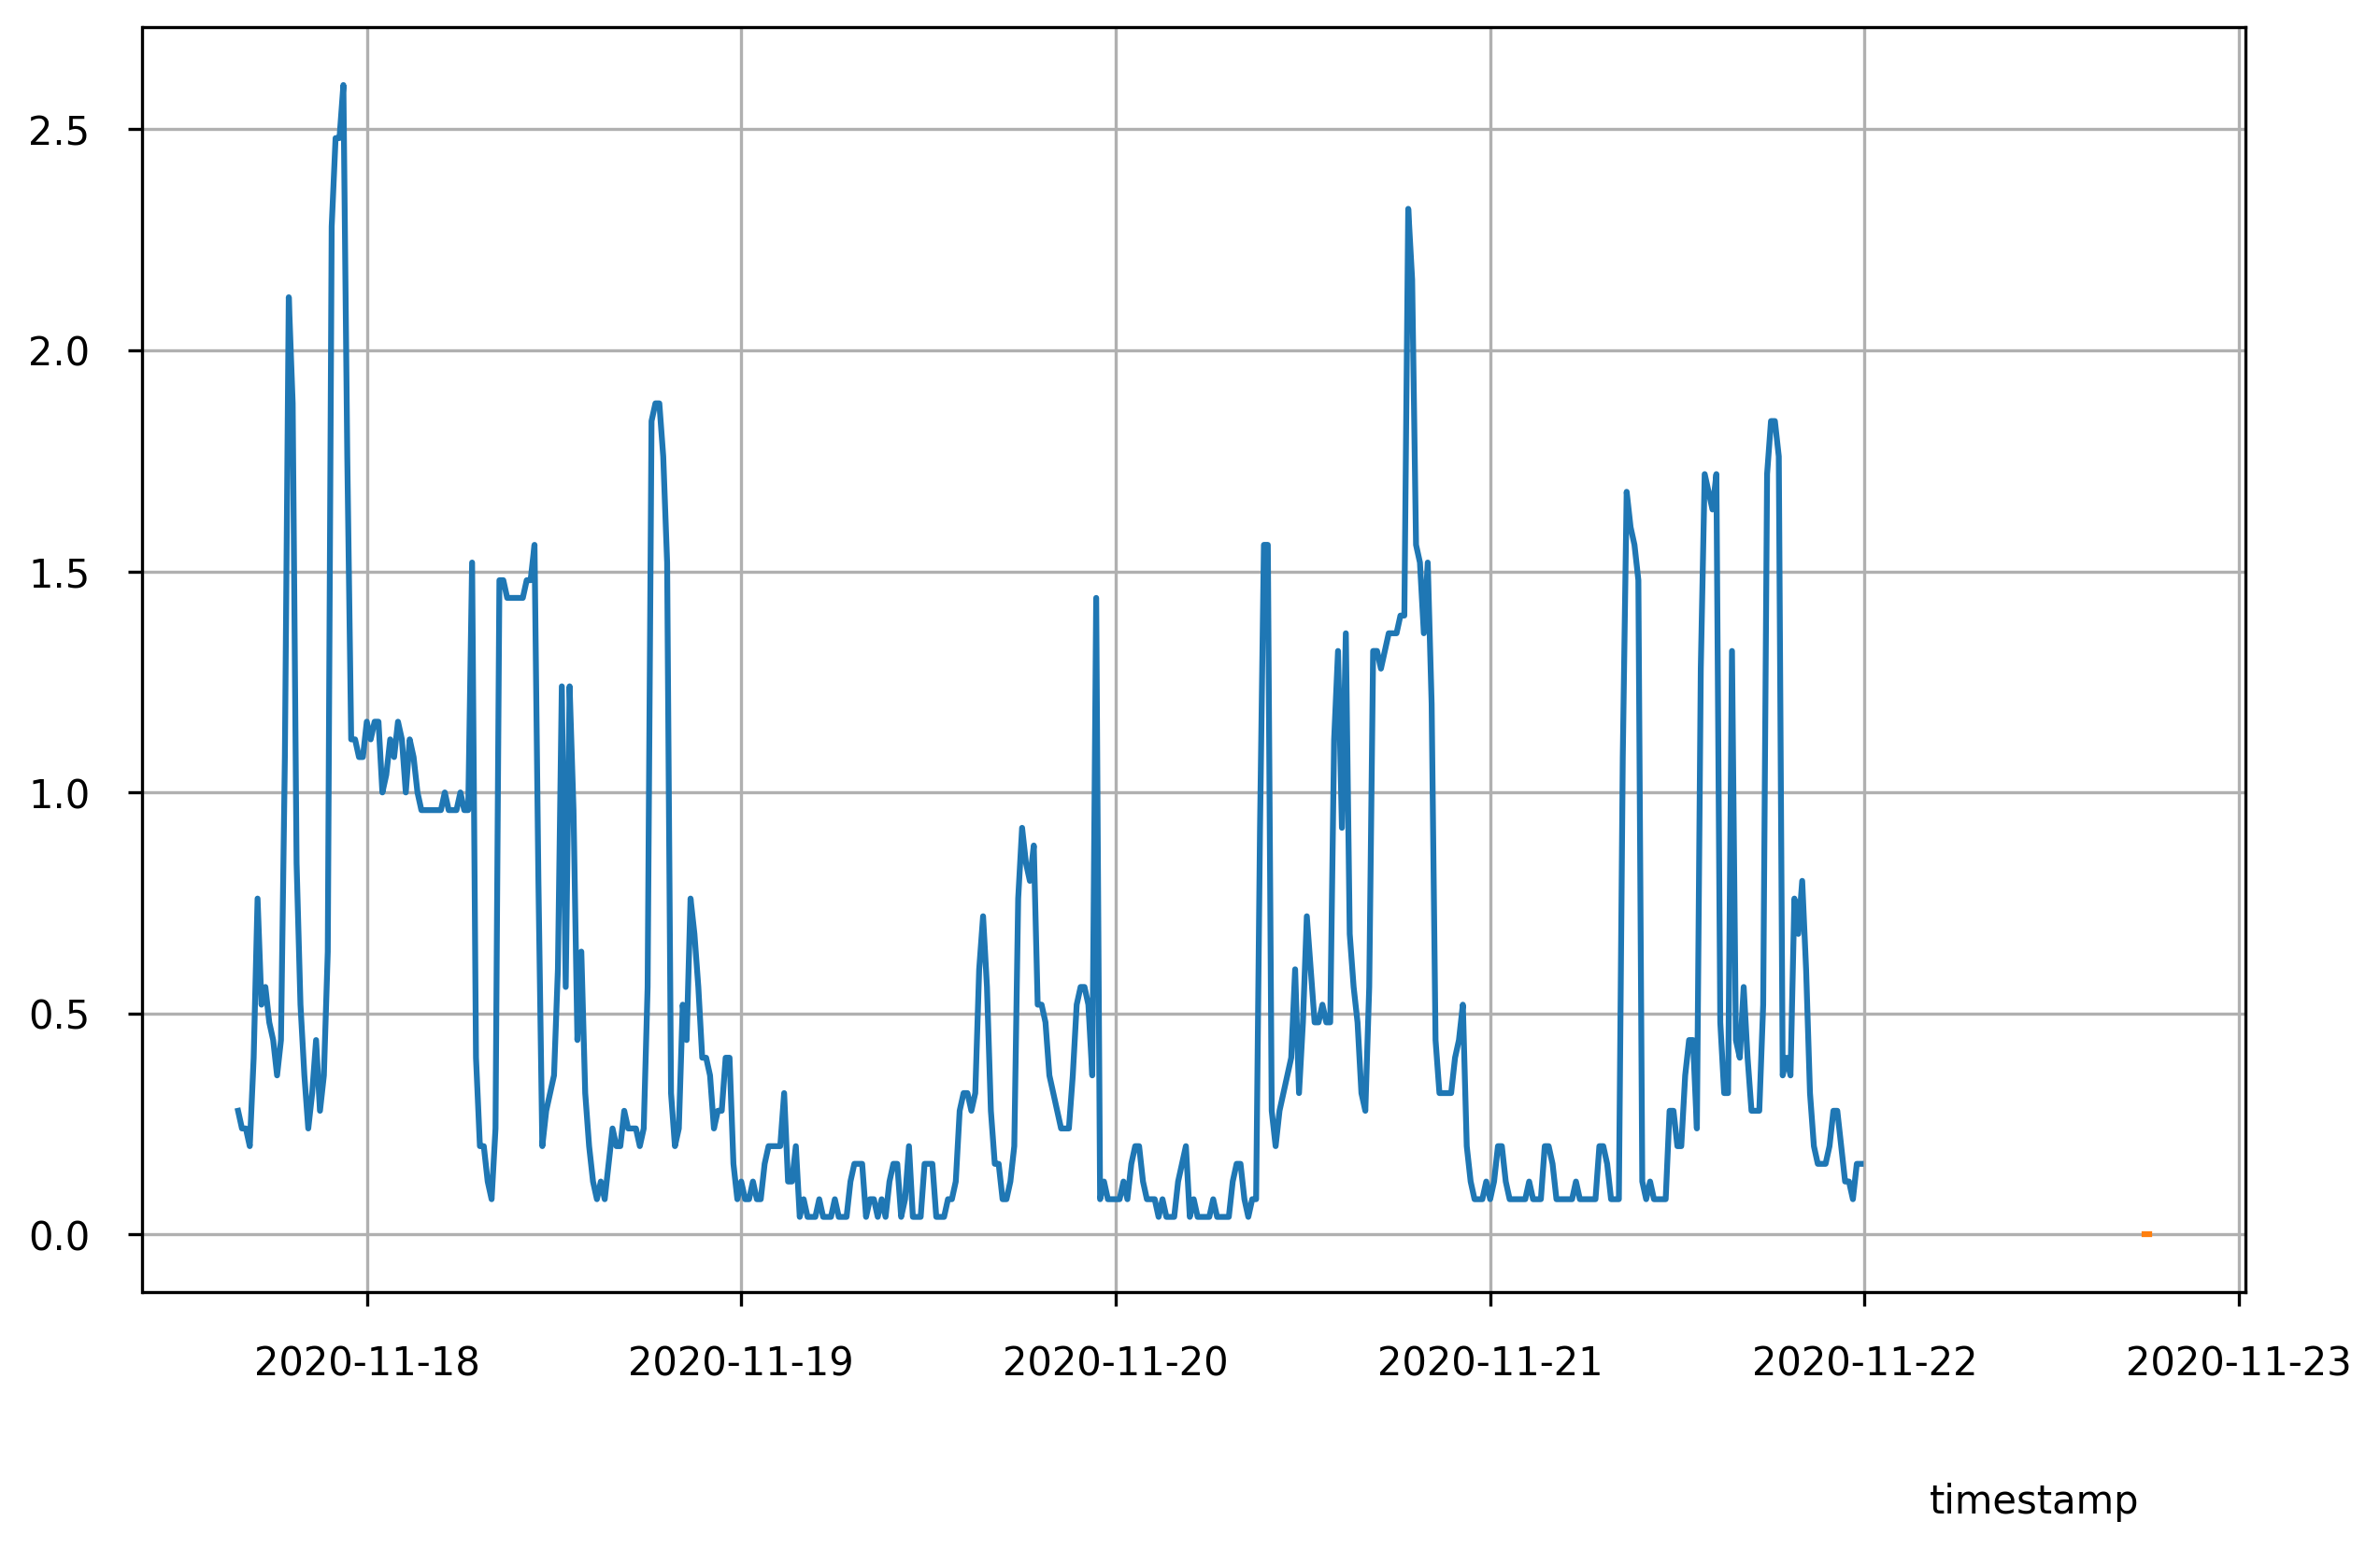

In [11]:
tick = datetime.datetime.now()

start = now - datetime.timedelta(days=5)
query = ''' SELECT timestamp, power/1000 as power FROM power
            WHERE timestamp > '{start}'
            ORDER BY timestamp'''
query = query.format(start=start)
solar = pandas.read_sql(sql=query, con=db.engine, 
                        parse_dates='timestamp',
                        index_col='timestamp')

query = ''' SELECT timestamp, power FROM sce
            WHERE timestamp > '{start}'
            ORDER BY timestamp'''
query = query.format(start=start)
sce = pandas.read_sql(sql=query, con=db.engine, 
                      parse_dates='timestamp',
                      index_col='timestamp')

plot = plots.Plot()
plot.plot_pandas(sce['power'])
plot.plot_pandas(solar['power'])
plot.set_daily_ticks()
plot.ax.xaxis.grid(True)
print(datetime.datetime.now()- tick)

# Explain November 2020 hike

In [29]:
sce = pandas.read_sql(sql='sce', con=db.engine, 
                      parse_dates='timestamp',
                      index_col='timestamp')

<AxesSubplot:xlabel='timestamp'>

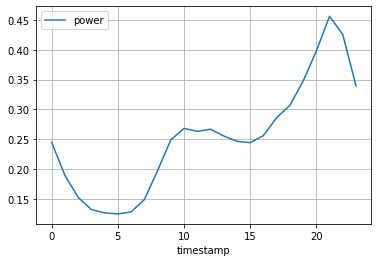

In [32]:
sce.groupby(sce.index.hour).mean().plot(grid='on')

<AxesSubplot:xlabel='timestamp'>

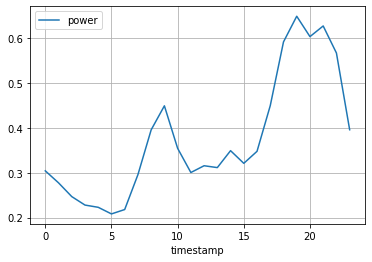

In [37]:
roi = sce[sce.index>'2020-09-01']
roi.groupby(roi.index.hour).mean().plot(grid='on')

# Average hourly production per month

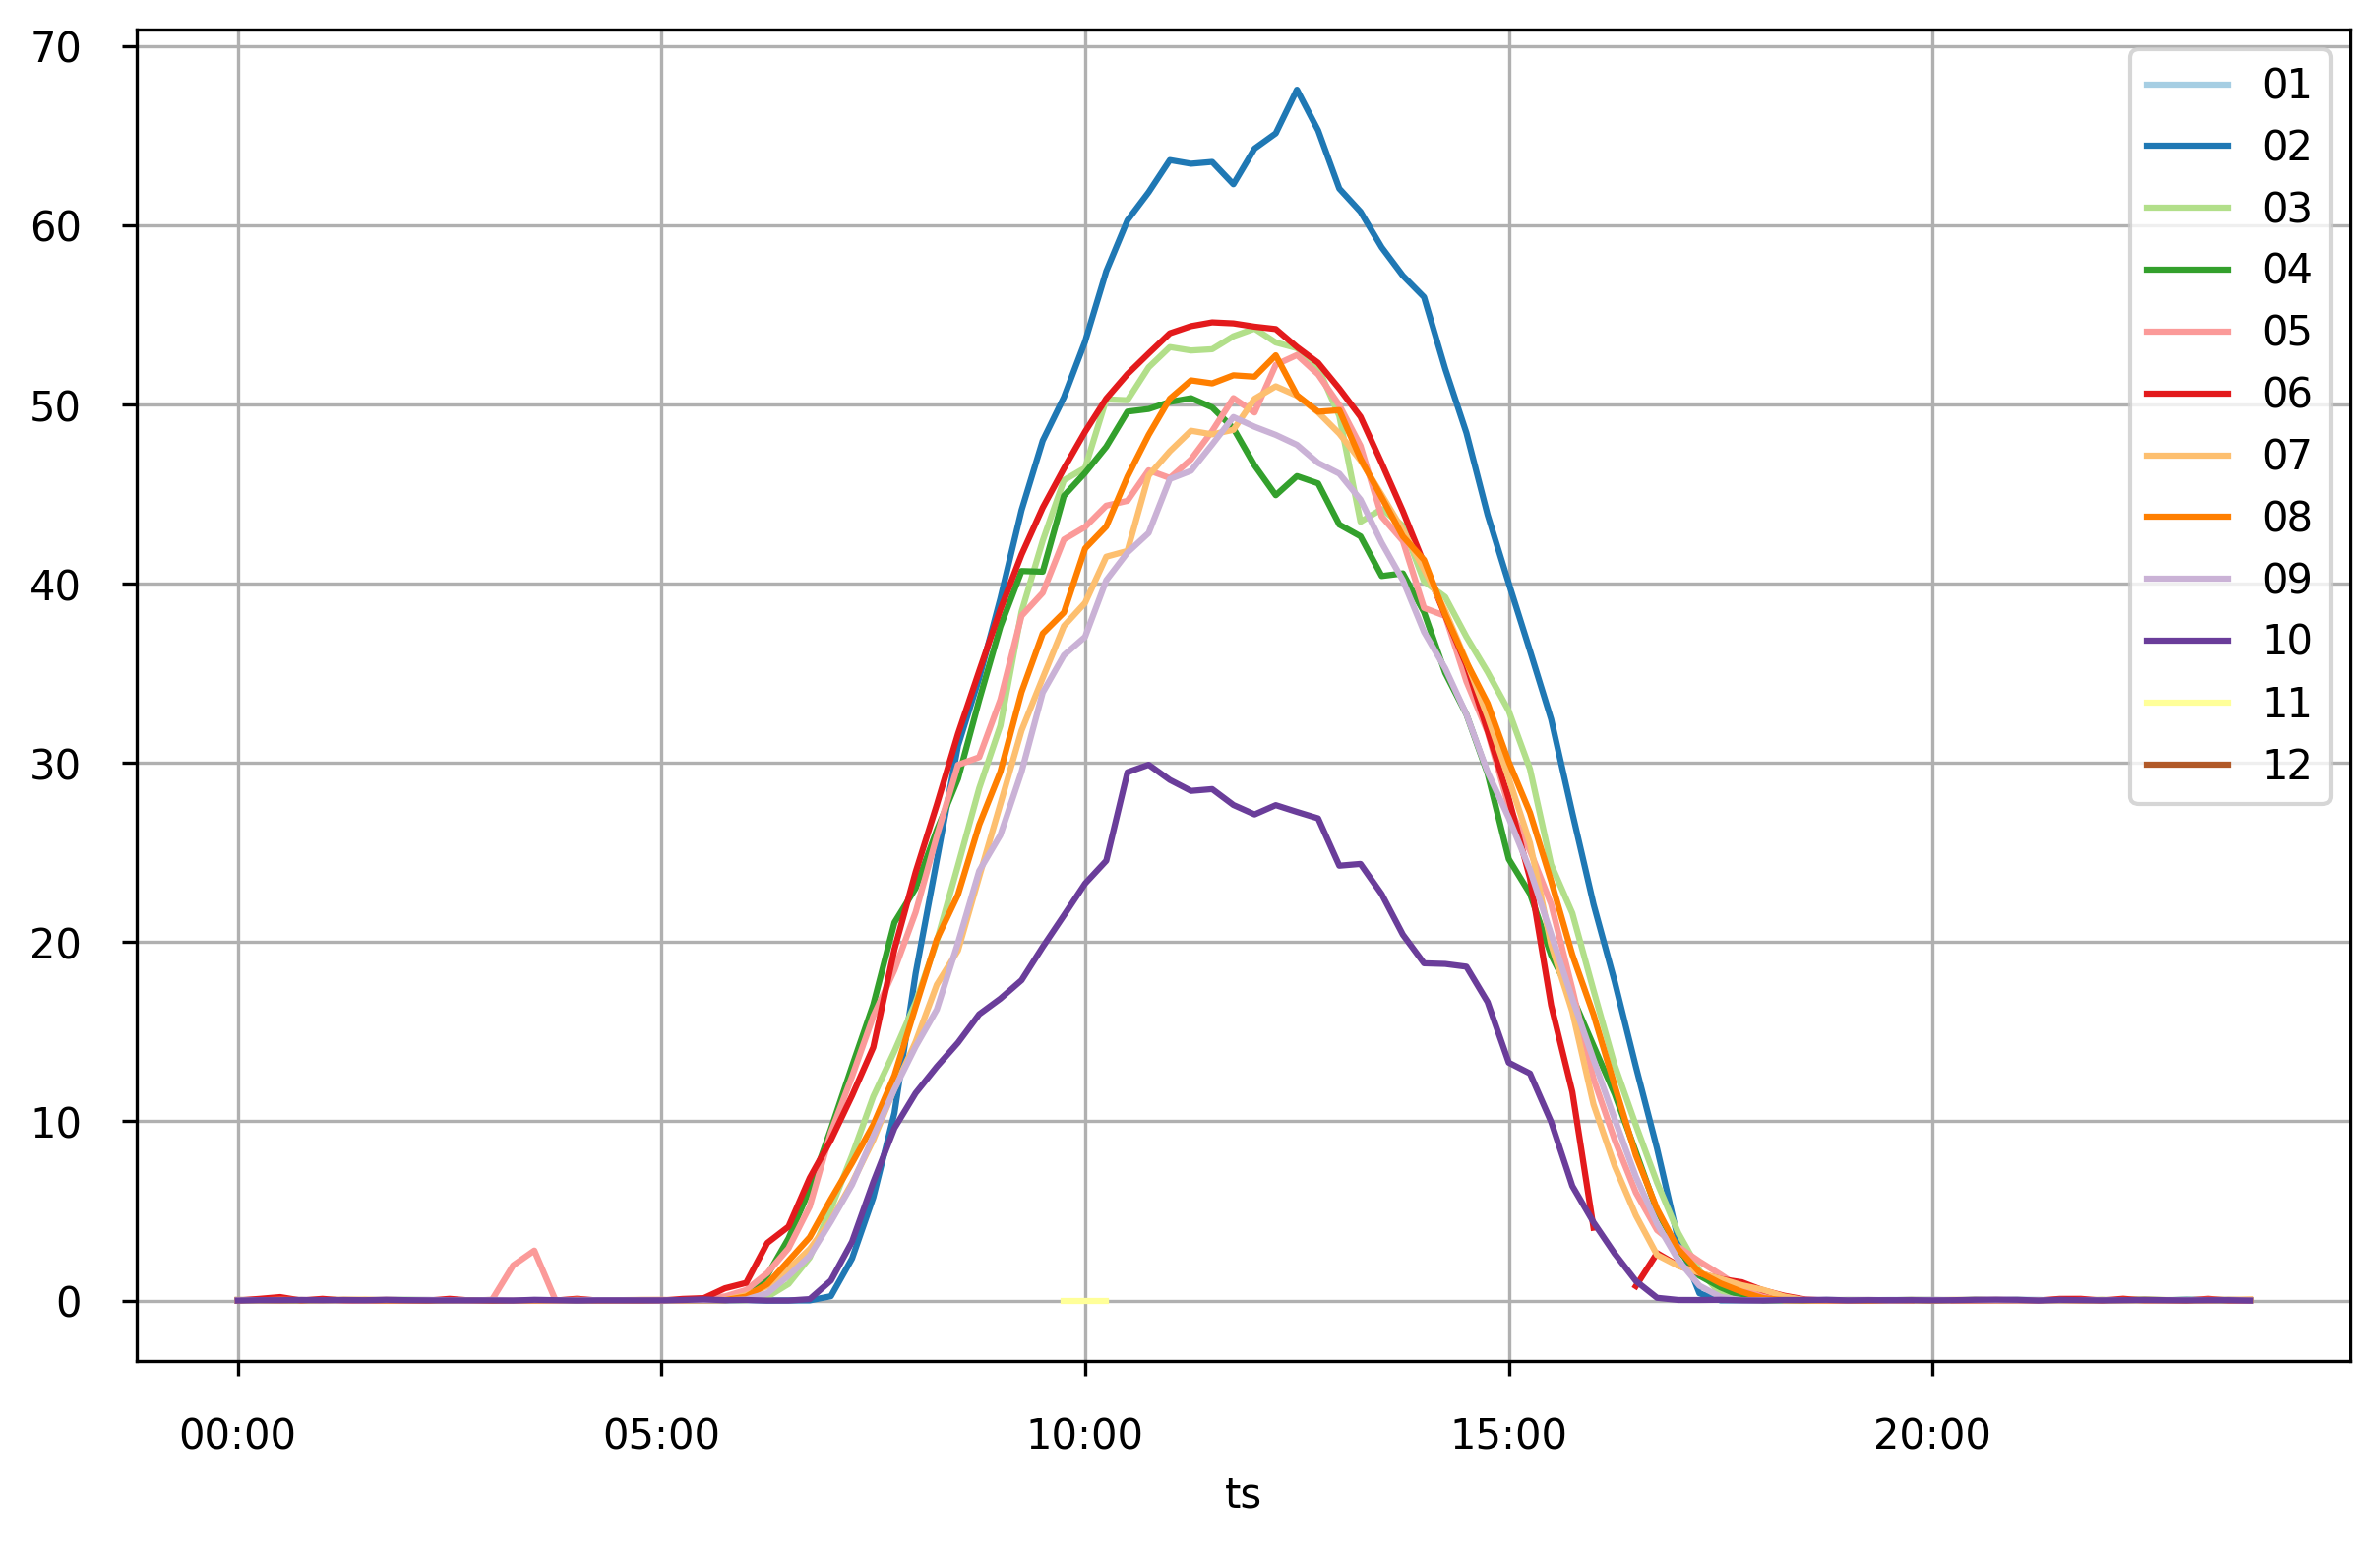

In [12]:
plot = plots.Plot()
query = '''SELECT minute, power 
           FROM solar_avg_15minute 
           WHERE month="{month}"'''
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

s = []
for month in months:
    s.append(pandas.read_sql(sql=query.format(month=month), 
                             con=db.engine, 
                             index_col='minute'))

df = pandas.concat(s, axis=1)
df.columns = months

df['ts'] = (pandas.to_datetime(df.index)-datetime.timedelta(hours=8)).strftime('%H:%M')
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)
plot.plot_pandas_df(df, colormap='Paired')

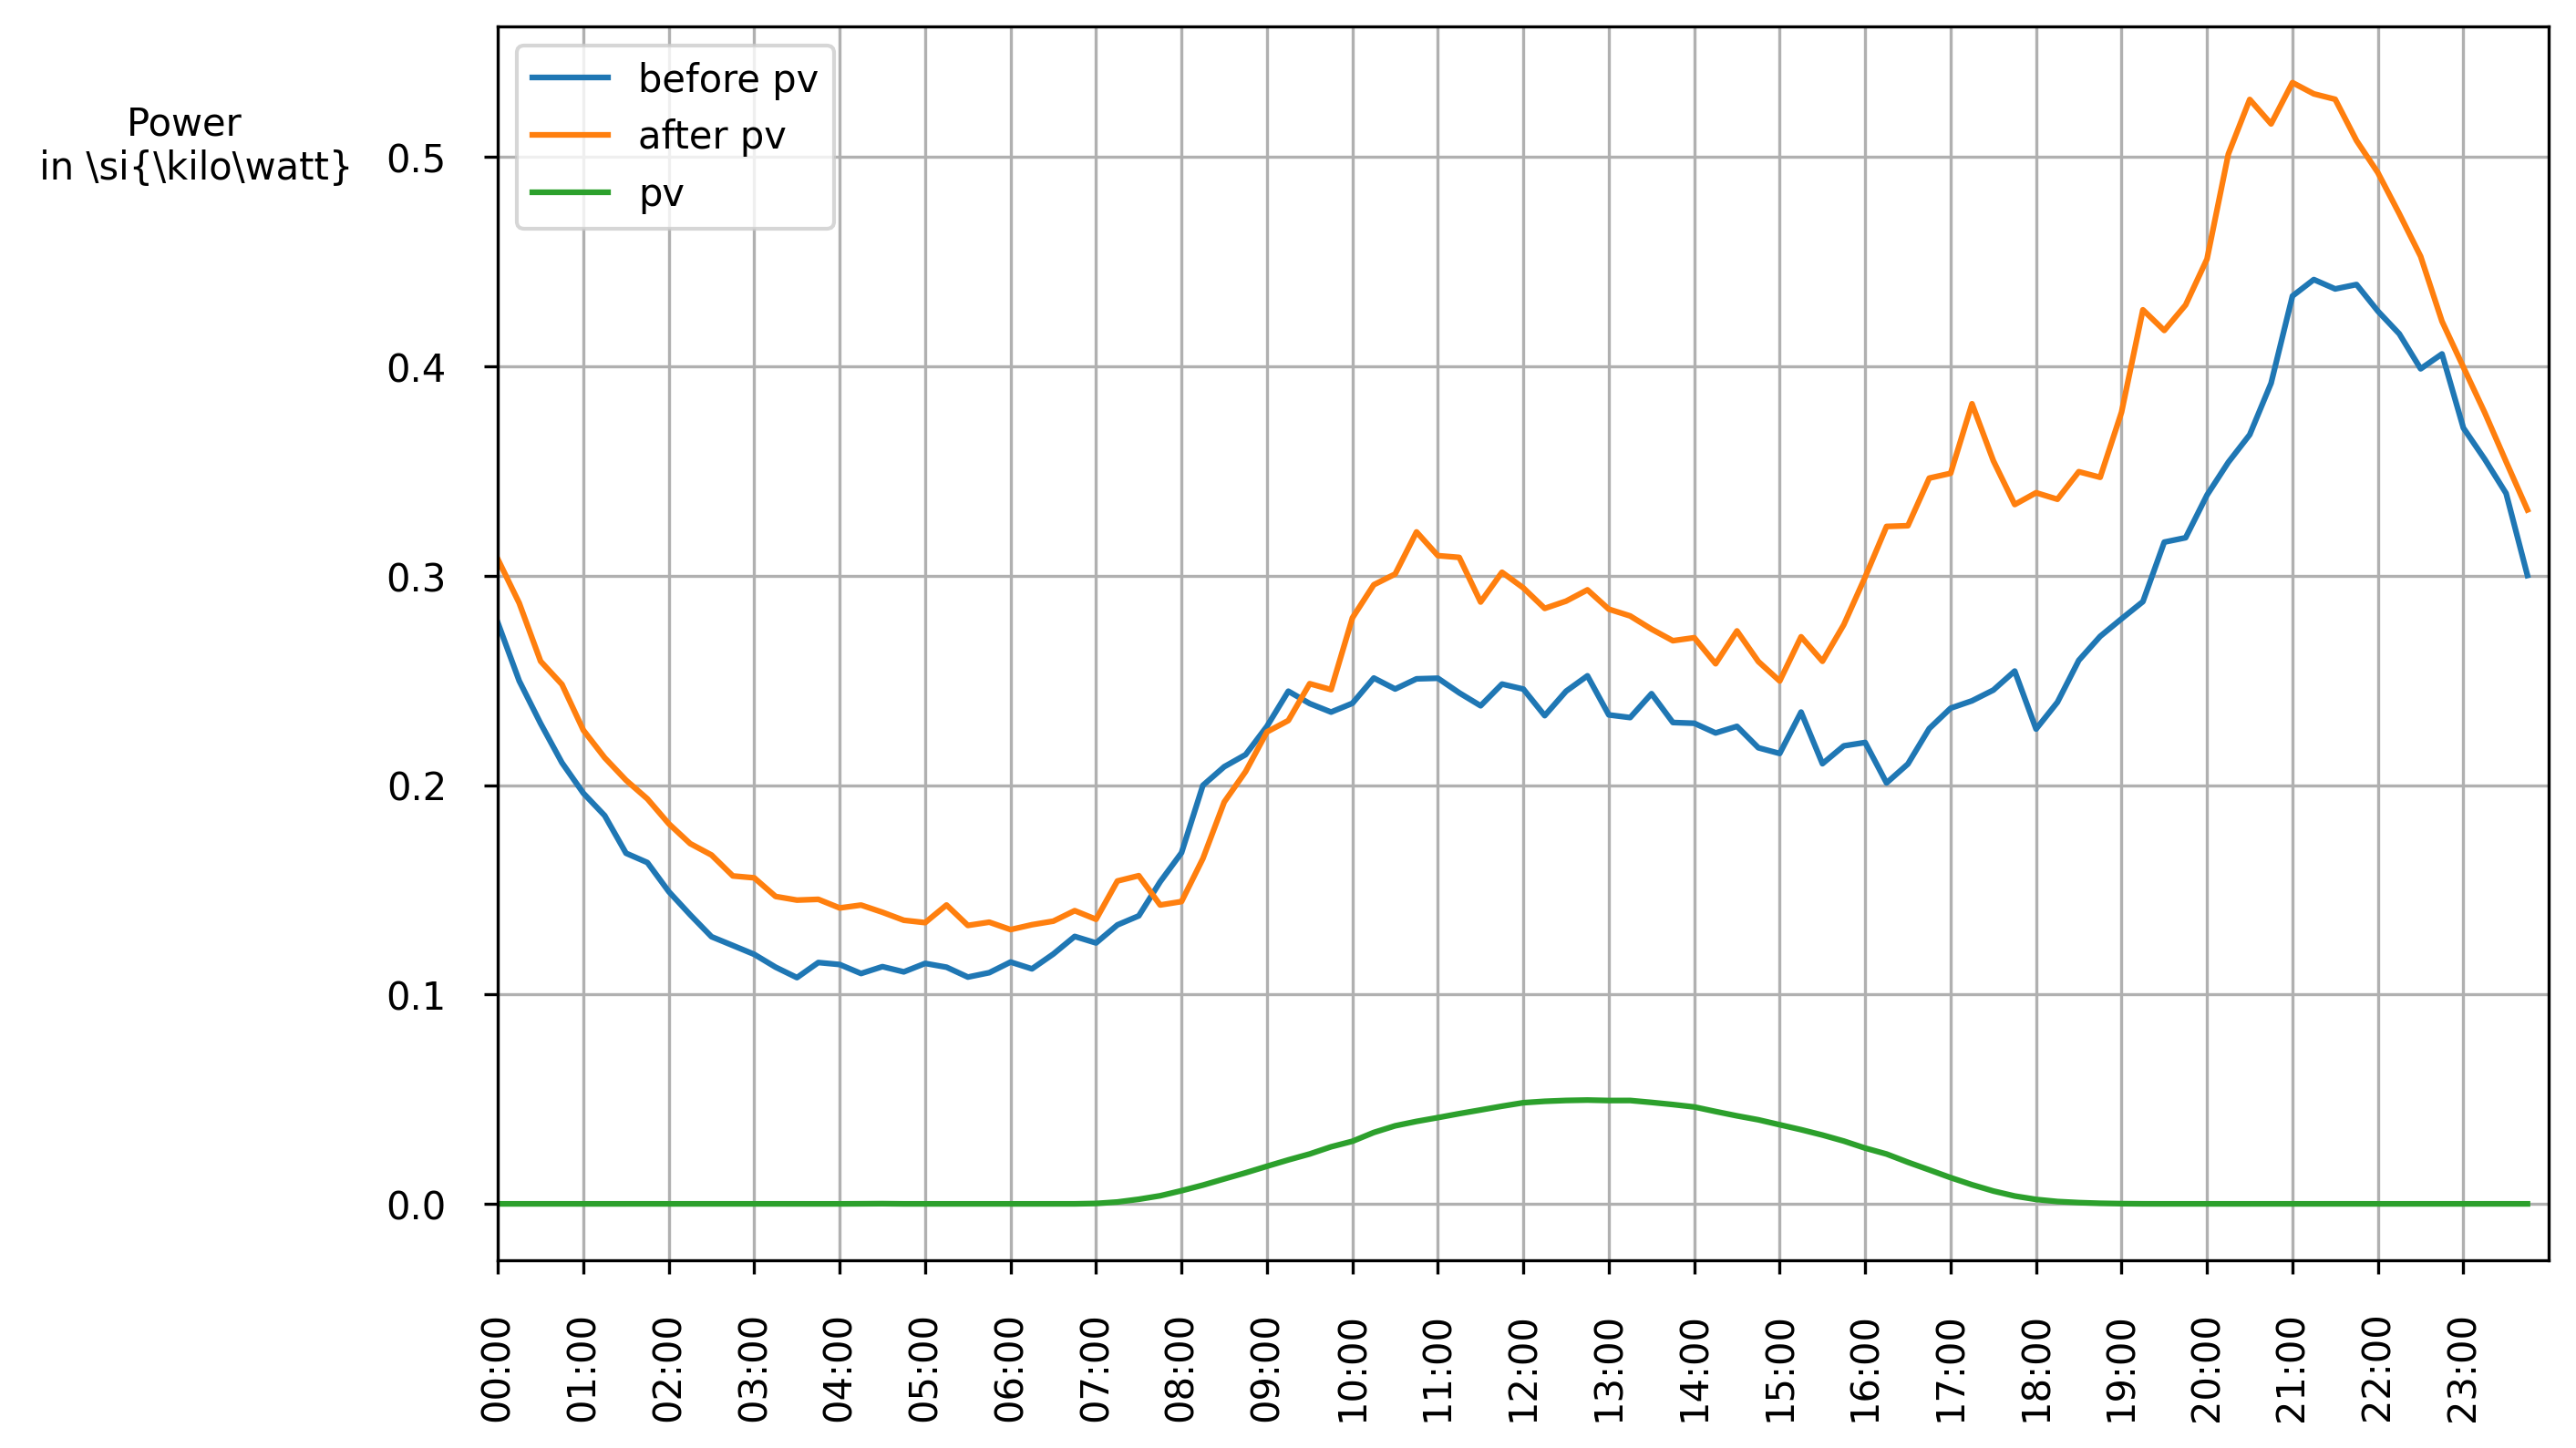

In [13]:
query = ''' SELECT STRFTIME(\'%H:%M\', timestamp) AS quarterhour, 
                    avg(solar) AS solar, 
                    avg(sce) AS sce
            FROM merged_quarterhour
            WHERE timestamp >= "{min_date}" 
            AND timestamp <= "{max_date}" 
            GROUP BY quarterhour 
            ORDER BY quarterhour '''

sql = query.format(min_date='2019-04-01', max_date='2025-02-01')
merged = pandas.read_sql(sql=sql, con=db.engine)
before_pv = sce_table.to_quarterhour_dataframe(min_date='2019-04-01', max_date='2020-02-01')

plot = plots.Plot()

plot.y_label('Power \n in \si{\kilo\watt}')
plot.plot_pandas(before_pv['power'], series_name='before pv')
plot.plot_pandas(merged['sce'], series_name='after pv')
plot.plot_pandas(merged['solar'], series_name='pv')

plot.set_xlim(0, 24*4)
plot.ax.set_xticks(range(0,24*4,4))
plot.rotate_ticks(90)
plot.show()

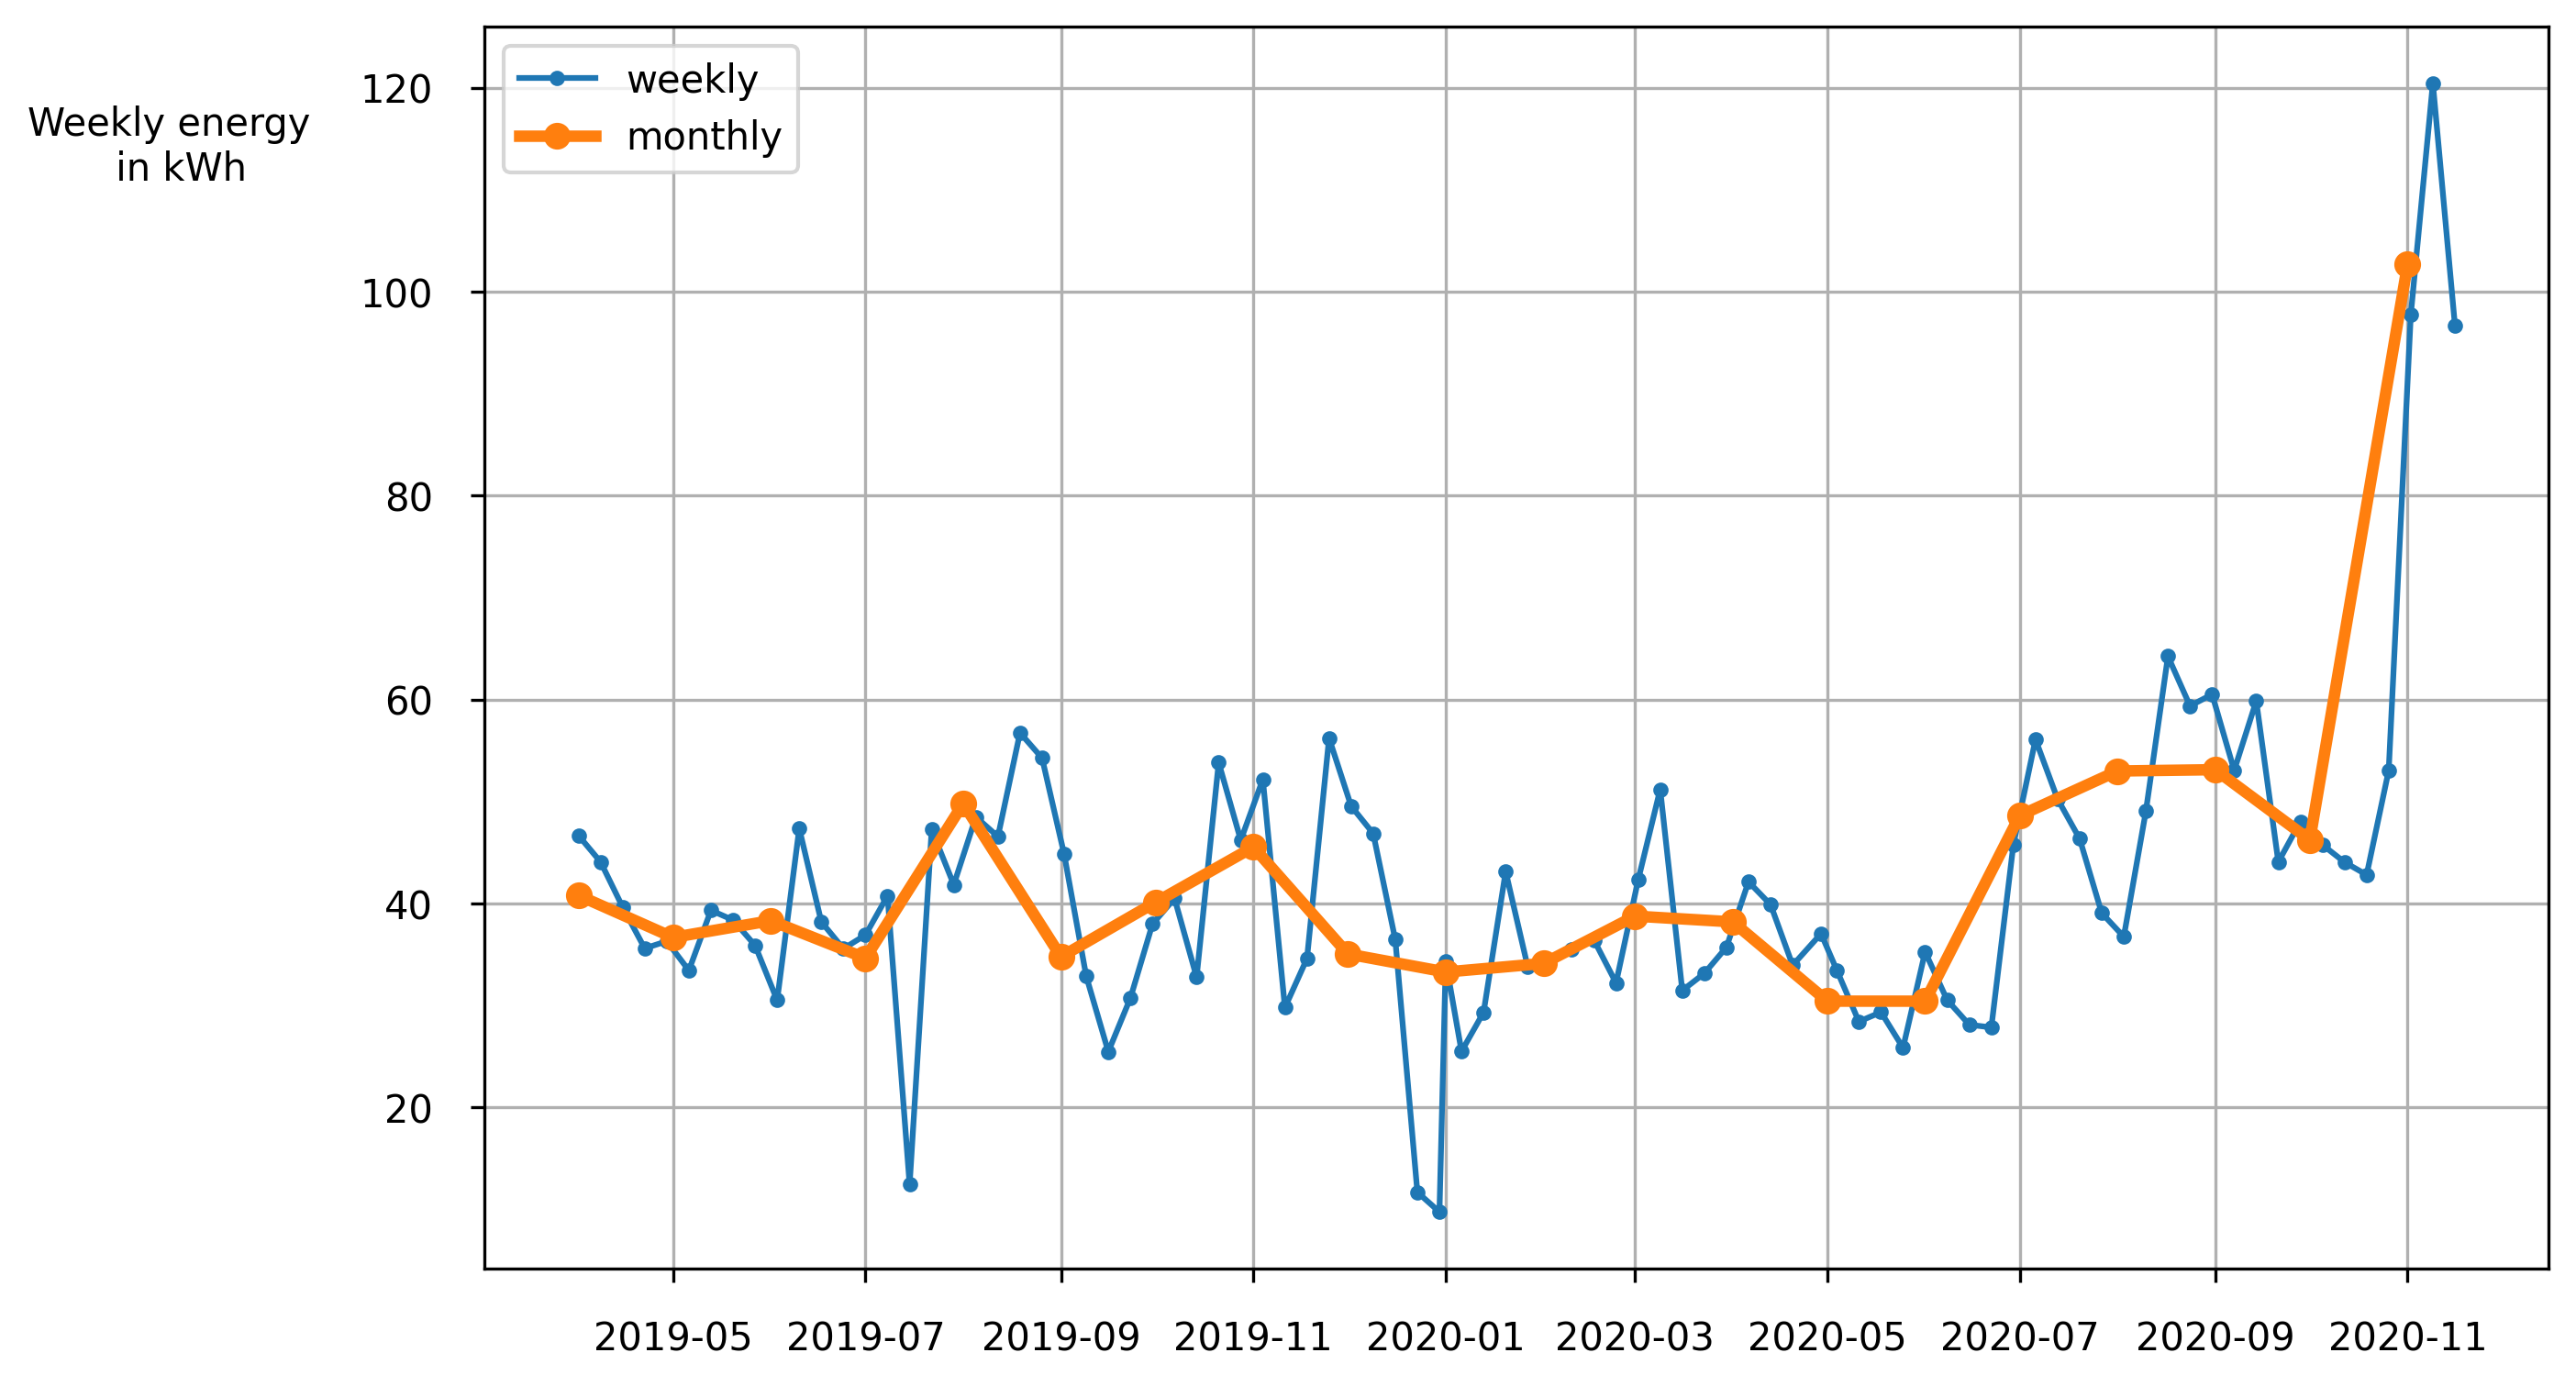

In [14]:
plot = plots.Plot()
plot.y_label('Weekly energy \n in kWh')

query = ''' SELECT strftime('%Y-%m-%d', timestamp) AS week,
            AVG(power)*168 AS weekly
            FROM sce
            GROUP BY strftime('%Y-%W', timestamp)'''

week_avg = pandas.read_sql(sql=query, con=db.engine,                         
                     index_col='week',
                    parse_dates='week')

query = ''' SELECT min(strftime('%Y-%m-%d', timestamp)) AS month,
            AVG(power)*168 AS monthly
            FROM sce
            GROUP BY strftime('%Y-%m', timestamp)'''

month_avg = pandas.read_sql(sql=query, con=db.engine,                         
                     index_col='month',
                     parse_dates='month')

plot.plot_pandas(week_avg['weekly'], marker='.')
plot.plot_pandas(month_avg['monthly'], marker='o', linewidth=3)
plot.make_legend()
plot.x_label('')
#plot.rotate_ticks(90)

In [15]:
sce_table.avg_daily('2019-04-01', '2020-02-01')
sce_table.avg_daily('2020-02-01', '2025-02-01')
day_tab = database.DBTable(db)
day_tab.get_value('SELECT avg(energy) FROM day')

0.33102459016393415

In [16]:
solar_table.self_consumption_rate()

0.9924891878404684

In [17]:
query = "SELECT strftime('%W', timestamp) as week, avg(energy)*7 as energy FROM day GROUP BY week"